# PS5E3: Models_with_Feature_Engineering_v1

## Import Libraries

In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hongkongrainfall/hongkong.csv
/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [48]:
# Basic data handling
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder

# Model evaluation & validation
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Boosting frameworks
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Optimization
import optuna

# Deep learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [49]:
# Load competition data
# - Training dataset
train_data = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv').set_index('id')

# - Testing dataset
test_data = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv').set_index('id')

# Load original data (Hong Kong rainfall dataset)
original = pd.read_csv("/kaggle/input/hongkongrainfall/hongkong.csv", encoding='latin-1')

# Load submission template
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')

## EDA Strategy:
1. First, look briefly at original data to get more insights about the competition data
2. Second, look closely at competition data (train data)

## Variable Descriptions:
* **Day**: Sequential identifier for observations
* **Pressure**: Atmospheric pressure measurement (unit: hPa)
* **Maxtemp**: Daily maximum temperature (unit: °C)
* **Temperature**: Daily average temperature (unit: °C)
* **Mintemp**: Daily minimum temperature (unit: °C)
* **Dewpoint**: Dew point temperature (unit: °C)
   * Temperature at which water vapor in the air condenses into dew
   * Closely related to humidity - smaller difference between temperature and dewpoint indicates higher humidity
   * Important indicator for rainfall prediction
* **Humidity**: Relative humidity ratio
* **Cloud**: Cloud coverage ratio
* **Sunshine**: Hours of sunshine
* **Winddirection**: Wind direction (unit: degrees)
* **Windspeed**: Wind speed (unit: km/h)
* **Rainfall**: Target variable - indicates rainfall occurrence (1) or non-occurrence (0)

In [50]:
# Print basic dataset information
print("\nData shape (rows, columns):")
print(original.shape)

# Display column names
print("\nColumn information:")
print(original.columns)

# Preview first 5 rows
print("\nFirst 5 rows of data:")
print(original.head())

# Summary statistics for numerical columns
print("\nStatistical information:")
print(original.describe())

# Check data types for each column
print("\nData type information:")
print(original.dtypes)

# Check for missing values in each column
print("\nMissing value check:")
print(original.isnull().sum())


Data shape (rows, columns):
(3591, 17)

Column information:
Index(['year', 'month', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'rainfall', 'low visibility hour',
       'sunshine', 'radiation', 'evaporation', 'winddirection', 'windspeed'],
      dtype='object')

First 5 rows of data:
   year  month  day  pressure  maxtemp  temparature  mintemp  dewpoint  \
0  2010      1    1    1018.1     18.1         16.2     15.0      11.4   
1  2010      1    2    1016.1     20.0         17.4     16.1      15.4   
2  2010      1    3    1017.1     18.3         17.0     15.8      14.7   
3  2010      1    4    1015.1     19.9         17.9     15.9      14.6   
4  2010      1    5    1015.6     18.5         17.3     15.9      14.5   

   humidity  cloud rainfall  low visibility hour sunshine radiation  \
0        73     84     Î¢Á¿                 17.0      2.7      9.86   
1        88     88      5.2                  3.0      0.5      6.74   
2  

In [51]:
# Explore rainfall data
print("Rainfall data type:", original['rainfall'].dtype)
print("Unique rainfall values:", original['rainfall'].unique())
print("Rainfall value distribution:\n", original['rainfall'].value_counts())

Rainfall data type: object
Unique rainfall values: ['Î¢Á¿' '5.2' '3.5' '-' '0.8' '1.2' '0.5' '0.9' '12.5' '0.4' '94.1' '7.1'
 '1.7' '2.3' '0.6' '1' '3.7' '0.1' '0.3' '4.9' '2.7' '8.9' '2' '1.8' '9.6'
 '8.2' '3.1' '1.1' '6.8' '0.2' '40.6' '29.1' '3.9' '27.6' '0.7' '11.9'
 '55.7' '8.1' '10.1' '22.6' '5.3' '16.1' '29.3' '16.7' '58.4' '29' '6.4'
 '3.8' '1.9' '1.4' '4.6' '41' '39' '2.9' '127.6' '44.2' '43.2' '8.4'
 '17.8' '40' '29.6' '182.4' '14.6' '33.6' '122.5' '5.1' '41.6' '1.6'
 '39.1' '18' '22.2' '3' '8.7' '13.5' '3.2' '56.4' '22.1' '9.1' '23.7'
 '42.6' '30.1' '16.2' '47.4' '22.5' '58.8' '51.8' '95.9' '67' '178.8'
 '4.4' '2.2' '10.2' '24.3' '14.7' '12.9' '4.2' '17' '2.4' '11.1' '26.7'
 '6.3' '33.5' '14.5' '7.5' '42.8' '69.8' '9.3' '2.8' '11.6' '28.4' '5.9'
 '75.2' '77.5' '8.3' '41.4' '106.6' '76.5' '11.2' '33.2' '10.9' '21.8'
 '12.4' '34.9' '60.5' '4.3' '5.6' '15.2' '9.9' '17.9' '8.5' '13.7' '2.6'
 '20.4' '2.5' '30.8' '12.7' '3.3' '6.9' '105.8' '30.7' '1.5' '13.9' '18.1'
 '8.6' '19.1' 

### Discrepancies Between Original Data and Competition Data

#### 1. Data Source
* Competition data combines portions of Hong Kong weather data from 2015 and 2016
* Not complete annual data, but a mix of January-July 2016 and August-December 2015

#### 2. Variable Structure Differences
* Original data: Contains additional variables such as 'year', 'month', 'low visibility hour', 'radiation', 'evaporation'
* Competition data: Selectively uses only a subset of variables

#### 3. Missing Value Inconsistencies
* Original data: Missing values in 'low visibility hour'(1), 'evaporation'(3), 'windspeed'(1)
* Competition data: One missing value in 'winddirection' in the test set

#### 4. Data Quality Issues
* According to forum discussions, 'winddirection' and 'windspeed' values don't match the original
* Original 'rainfall' variable has diverse values: (no rain), `微量`(trace amounts), numeric values (0.1~52.1)
* Analysis of original data: '-' (1351 instances of no rain), `微量`/`Î¢Á¿` (770 instances for trace amounts), and numeric values ranging from 0.1 to 52.1 (total of 439 instances with measurable rainfall)
* In the competition, all rainfall information is binarized to simply 0 (no rain) and 1 (rain)

In [52]:
# Explore competition training data
print("\nData shape (rows, columns):")
print(train_data.shape)

# Display column names
print("\nColumn information:")
print(train_data.columns)

# Preview first 5 rows
print("\nFirst 5 rows of data:")
print(train_data.head())

# Summary statistics for numerical columns
print("\nStatistical information:")
print(train_data.describe())

# Check data types for each column
print("\nData type information:")
print(train_data.dtypes)

# Check for missing values in each column
print("\nMissing value check:")
print(train_data.isnull().sum())


Data shape (rows, columns):
(2190, 12)

Column information:
Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall'],
      dtype='object')

First 5 rows of data:
    day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
id                                                                            
0     1    1017.4     21.2         20.6     19.9      19.4      87.0   88.0   
1     2    1019.5     16.2         16.9     15.8      15.4      95.0   91.0   
2     3    1024.1     19.4         16.1     14.6       9.3      75.0   47.0   
3     4    1013.4     18.1         17.8     16.9      16.8      95.0   95.0   
4     5    1021.8     21.3         18.4     15.2       9.6      52.0   45.0   

    sunshine  winddirection  windspeed  rainfall  
id                                                
0        1.1           60.0       17.2         1  
1        0.0          

In [ ]:
# Set graph size
plt.figure(figsize=(15, 10))

# Select numerical columns
numeric_columns = train_data.select_dtypes(include=['int64', 'float64']).columns

# Create histograms
for i, column in enumerate(numeric_columns):
    if column != 'id' and column != 'rainfall':  # Exclude target variable and ID
        plt.subplot(3, 4, i + 1)
        sns.histplot(train_data[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.tight_layout()

plt.show()

In [ ]:
# Visualize target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='rainfall', data=train_data)
plt.title('Target Variable Distribution (rainfall)')
plt.ylabel('Count')

rain_counts = [train_data['rainfall'].value_counts()[0], train_data['rainfall'].value_counts()[1]]

for i, count in enumerate(rain_counts):
    plt.text(i, count + 10, f'{count} ({count/len(train_data):.1%})', 
             ha='center', va='bottom')
plt.show()

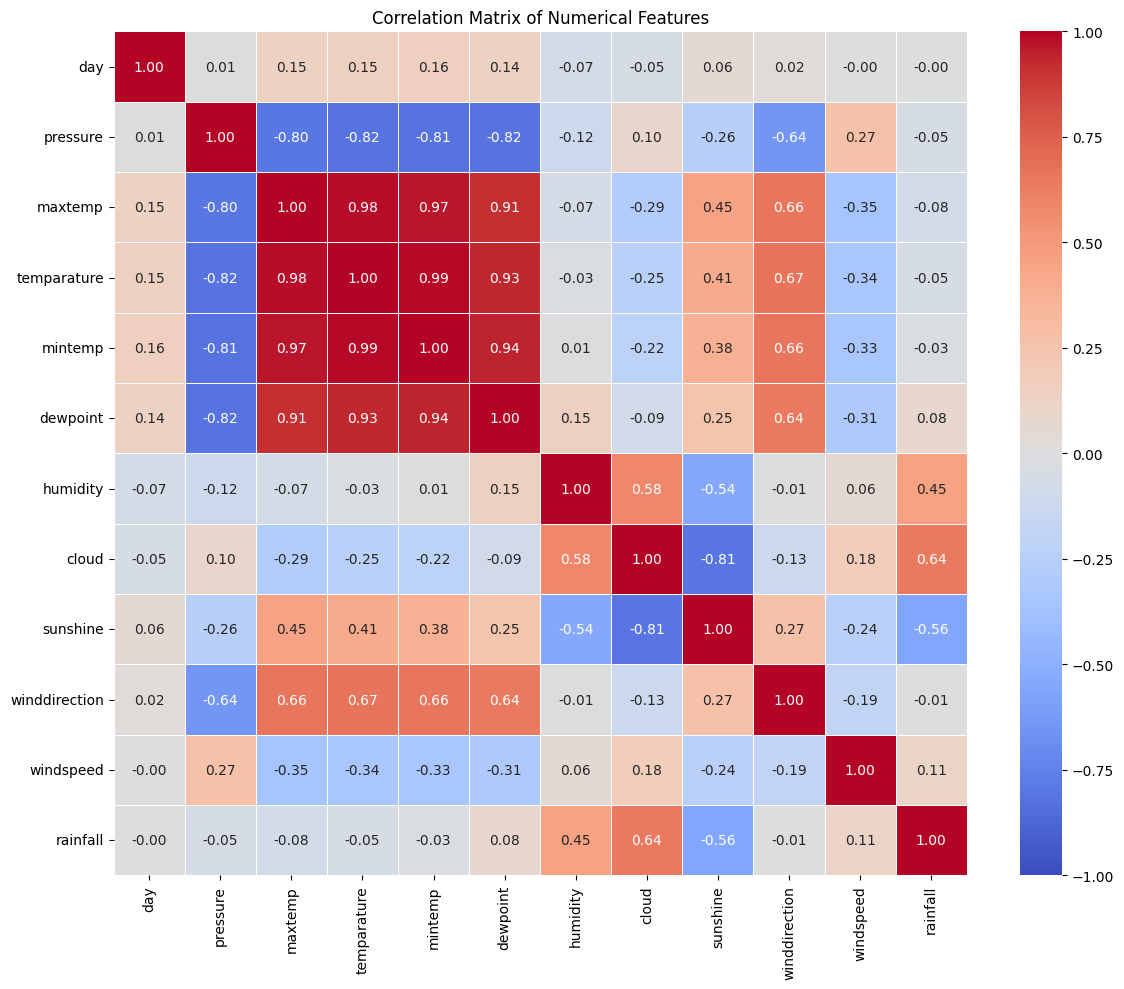

Features correlation with target (rainfall):
rainfall         1.000000
cloud            0.641191
humidity         0.454213
windspeed        0.111625
dewpoint         0.081965
day             -0.000462
winddirection   -0.006939
mintemp         -0.026841
temparature     -0.049660
pressure        -0.049886
maxtemp         -0.079304
sunshine        -0.555287
Name: rainfall, dtype: float64


In [55]:
# Check correlation between numerical variables
plt.figure(figsize=(12, 10))
corr = train_data.select_dtypes(include=['int64', 'float64']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Print correlation with target variable
target_corr = corr['rainfall'].sort_values(ascending=False)
print("Features correlation with target (rainfall):")
print(target_corr)

## Key Correlation Insights:

### Relationships with Target Variable (Rainfall):
* **Cloud (0.64)**: Cloud coverage is the strongest indicator for rainfall prediction
* **Sunshine (-0.56)**: Decreased sunshine hours indicates increased rainfall probability
* **Humidity (0.45)**: Higher humidity is associated with higher rainfall probability

### Multicollinearity Issues:
* Temperature, Maxtemp, and Mintemp contain almost identical information (correlation coefficients 0.97-0.99)
* Dewpoint also has high correlation with temperature variables (0.91-0.94)
* Cloud and Sunshine have strong negative correlation (-0.81)

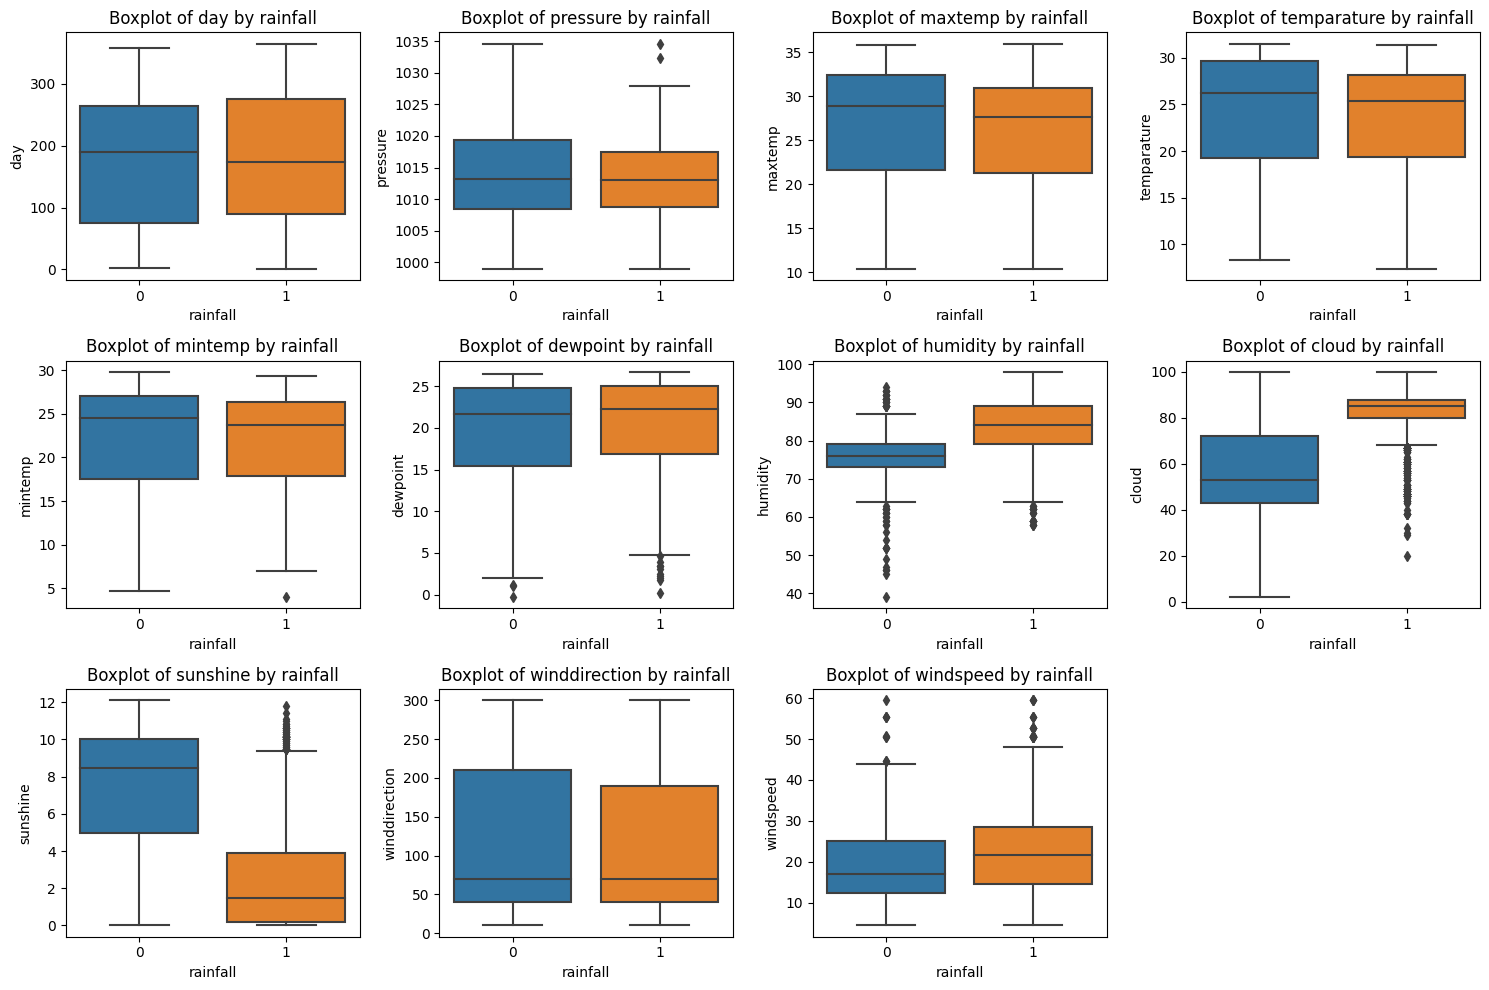

In [56]:
# Outlier detection
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns):
    if column != 'id' and column != 'rainfall':  # Exclude target variable and ID
        plt.subplot(3, 4, i + 1)
        sns.boxplot(x='rainfall', y=column, data=train_data)
        plt.title(f'Boxplot of {column} by rainfall')
        plt.tight_layout()
plt.show()

Data type of 'day': int64


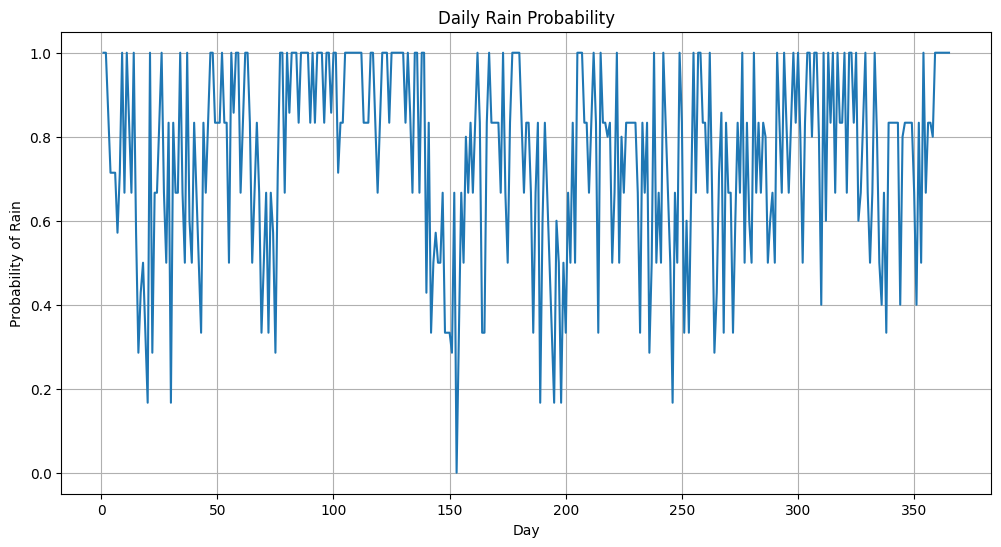

<Figure size 1200x600 with 0 Axes>

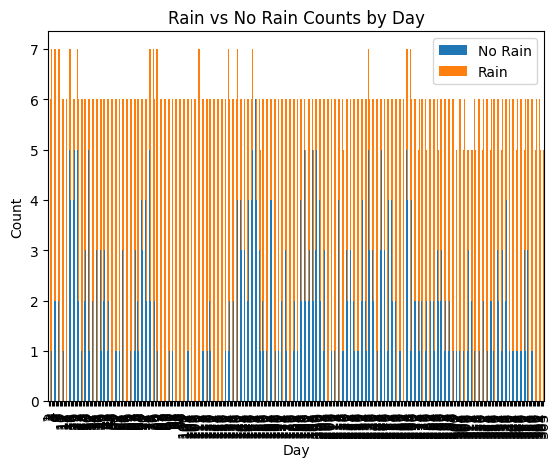

In [57]:
# Temporal Pattern Analysis using the 'day' variable
if 'day' in train_data.columns:
    # Check the data type of 'day'
    print(f"Data type of 'day': {train_data['day'].dtype}")
    
    # If 'day' is not already in datetime format, convert it if possible
    # (Skip this if 'day' is just a number without actual date meaning)
    
    # Analyze rainfall probability by day
    plt.figure(figsize=(12, 6))
    daily_rain_prob = train_data.groupby('day')['rainfall'].mean()
    daily_rain_prob.plot(kind='line')
    plt.title('Daily Rain Probability')
    plt.xlabel('Day')
    plt.ylabel('Probability of Rain')
    plt.grid(True)
    plt.show()
    
    # Count of rainy days vs non-rainy days by day
    plt.figure(figsize=(12, 6))
    rain_counts_by_day = pd.crosstab(train_data['day'], train_data['rainfall'])
    rain_counts_by_day.plot(kind='bar', stacked=True)
    plt.title('Rain vs No Rain Counts by Day')
    plt.xlabel('Day')
    plt.ylabel('Count')
    plt.legend(['No Rain', 'Rain'])
    plt.show()

### Key Observations:
* All data is numeric and mostly shows sinusoidal patterns
   * e.g. The probability of rain exhibits periodic patterns that rise and fall according to seasons. Time series patterns and seasonality should be reflected in the model.

## Feature Engineering
- Create circular encoding for wind direction (sin/cos transformation)
- Add interaction terms between Cloud, Sunshine, and Humidity (strongest predictors)
- Handle Temperature multicollinearity by selecting one temperature variable
- Create dewpoint depression feature (temperature - dewpoint)

In [58]:
# 1. Circular encoding for wind direction (sin/cos transformation)
def circular_encode(df):
    # Convert wind direction to radians (assuming wind direction is in 0-360 degree range)
    wind_rad = np.radians(df['winddirection'])
    
    # Add sin/cos transformations
    df['winddirection_sin'] = np.sin(wind_rad)
    df['winddirection_cos'] = np.cos(wind_rad)
    
    return df

In [59]:
# 2. Add interaction terms between Cloud, Sunshine, and Humidity
def add_interactions(df):
    # Convert Sunshine to numeric (assuming it's in time format)
    if 'sunshine' in df.columns and df['sunshine'].dtype == 'object':
        # Assuming time format is HH:MM, convert to hours
        try:
            df['sunshine_hours'] = df['sunshine'].apply(
                lambda x: float(x.split(':')[0]) + float(x.split(':')[1])/60 if pd.notna(x) and ':' in str(x) else np.nan
            )
        except:
            # It might be a simple numeric value
            df['sunshine_hours'] = pd.to_numeric(df['sunshine'], errors='coerce')
    else:
        df['sunshine_hours'] = df['sunshine']
    
    # Create interaction terms
    df['cloud_humidity'] = df['cloud'] * df['humidity']
    df['cloud_sunshine'] = df['cloud'] * df['sunshine_hours']
    df['humidity_sunshine'] = df['humidity'] * df['sunshine_hours']
    
    return df

In [60]:
# 3. Handle Temperature multicollinearity by selecting one temperature variable
def handle_temperature_multicollinearity(df):
    # Check correlation between temperature variables (uncomment to run)
    # temp_cols = ['temparature', 'maxtemp', 'mintemp']
    # print(df[temp_cols].corr())
    
    # Using the basic temperature and excluding others
    # Depending on the model, different temperature variables can be used
    
    # Create temperature range feature
    df['temp_range'] = df['maxtemp'] - df['mintemp']
    
    return df

In [61]:
# 4. Create dewpoint depression feature (temperature - dewpoint)
def create_dewpoint_depression(df):
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    return df

In [62]:
# Main Feature Engineering function
def engineer_features(df):
    df = df.copy()  # Preserve original data
    
    # Handle string format data (rainfall, sunshine, radiation, evaporation)
    # Convert to numeric as needed
    for col in ['rainfall', 'sunshine', 'radiation', 'evaporation']:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Apply each Feature Engineering step
    df = circular_encode(df)
    df = add_interactions(df)
    df = handle_temperature_multicollinearity(df)
    df = create_dewpoint_depression(df)
    
    return df

In [63]:
# Apply to train and test datasets
train_data = engineer_features(train_data)
test_data = engineer_features(test_data)

# 결과 확인
print(train_data.head())
print(train_data.shape)

    day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
id                                                                            
0     1    1017.4     21.2         20.6     19.9      19.4      87.0   88.0   
1     2    1019.5     16.2         16.9     15.8      15.4      95.0   91.0   
2     3    1024.1     19.4         16.1     14.6       9.3      75.0   47.0   
3     4    1013.4     18.1         17.8     16.9      16.8      95.0   95.0   
4     5    1021.8     21.3         18.4     15.2       9.6      52.0   45.0   

    sunshine  winddirection  windspeed  rainfall  winddirection_sin  \
id                                                                    
0        1.1           60.0       17.2         1           0.866025   
1        0.0           50.0       21.9         1           0.766044   
2        8.3           70.0       18.1         1           0.939693   
3        0.0           60.0       35.6         1           0.866025   
4        3.6        

In [64]:
# Select features and target variable
X = train_data.drop(['rainfall'], axis=1)
y = train_data['rainfall']
X_test = test_data.copy()

In [65]:
# Print columns with NaN values
print(X_test.isna().sum())

day                    0
pressure               0
maxtemp                0
temparature            0
mintemp                0
dewpoint               0
humidity               0
cloud                  0
sunshine               0
winddirection          1
windspeed              0
winddirection_sin      1
winddirection_cos      1
sunshine_hours         0
cloud_humidity         0
cloud_sunshine         0
humidity_sunshine      0
temp_range             0
dewpoint_depression    0
dtype: int64


### Handling Missing Value in wind direction columns

#### Implemented Approach: Mode Imputation

In [66]:
# Fill NaN values in wind direction columns with their respective modes
for col in ['winddirection', 'winddirection_sin', 'winddirection_cos']:
    X_test[col].fillna(X[col].mode()[0], inplace=True)

#### Pros and Cons of Mode Imputation

**Pros**:
* Simple to implement and easy to understand
* Low computational cost
* Effective for single missing values
* Mode may be more appropriate than median for circular data like wind direction

**Cons**:
* Doesn't provide information about missing patterns to the model
* Doesn't consider multivariate missing patterns
* May introduce bias when there are multiple missing values

#### Alternative Approach: Circular Mean for Directional Data
The commented code below shows an alternative approach that considers the circular nature of wind direction data:

In [67]:
# Alternative: Using circular mean for directional data
# Wind direction is circular data (0-360 degrees) requiring special handling for mean calculation
# import numpy as np
# angles = np.radians(x['winddirection'].dropna())
# mean_sin = np.mean(np.sin(angles))
# mean_cos = np.mean(np.cos(angles))
# mean_angle = np.degrees(np.arctan2(mean_sin, mean_cos)) % 360
# x_test['winddirection'].fillna(mean_angle, inplace=True)

## Models

In [68]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.05),
    "LightGBM": lgb.LGBMClassifier(random_state=42, n_estimators=100),
    "CatBoost": CatBoostClassifier(random_state=42, iterations=100, verbose=0)
}

def evaluate_all_models(X, y, X_test=None, test_index=None, folds=5):
    # Train models using StratifiedKFold CV
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    auc_scores = {}
    roc_curves = {}
    test_preds = {}
    
    for name, model in models.items():
        oof_preds = np.zeros(len(y))
        
        if X_test is not None:
            test_fold_preds = np.zeros((folds, len(X_test)))
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            if isinstance(model, lgb.LGBMClassifier):
                model.fit(X_train, y_train, 
                         eval_set=[(X_val, y_val)],
                         callbacks=[lgb.early_stopping(50, verbose=0)])
            elif isinstance(model, xgb.XGBClassifier):
                model.fit(X_train, y_train,
                         eval_set=[(X_val, y_val)],
                         early_stopping_rounds=50,
                         verbose=0)
            elif isinstance(model, CatBoostClassifier):
                model.fit(X_train, y_train,
                         eval_set=[(X_val, y_val)],
                         early_stopping_rounds=50,
                         verbose=0)
            else:
                model.fit(X_train, y_train)
            
            # Save out-of-fold predictions
            oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
            
            # Make test predictions if test data provided
            if X_test is not None:
                test_fold_preds[fold] = model.predict_proba(X_test)[:, 1]
        
        # Calculate AUC
        auc_score = roc_auc_score(y, oof_preds)
        auc_scores[name] = auc_score
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y, oof_preds)
        roc_curves[name] = (fpr, tpr, auc_score)
        
        # Average test predictions across folds
        if X_test is not None:
            test_preds[name] = test_fold_preds.mean(axis=0)
        
        print(f"{name}: AUC = {auc_score:.4f}")
    
    return auc_scores, test_preds

In [69]:
# Model evaluation
auc_scores, test_predictions = evaluate_all_models(
    X, y, 
    X_test=X_test,
    test_index=test_data.index,
    folds=5
)

# Check the best model
best_model = max(auc_scores.items(), key=lambda x: x[1])[0]
print(f"\nThe best model: {best_model}, AUC = {auc_scores[best_model]:.4f}")

submission = pd.DataFrame({
    'id': test_data.index,
    'rainfall': test_predictions[best_model]
})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file saved as 'submission.csv'.")

Logistic Regression: AUC = 0.8927
Random Forest: AUC = 0.8788
Gradient Boosting: AUC = 0.8758
XGBoost: AUC = 0.8777
[LightGBM] [Info] Number of positive: 1320, number of negative: 432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2785
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753425 -> initscore=1.116961
[LightGBM] [Info] Start training from score 1.116961
[LightGBM] [Info] Number of positive: 1320, number of negative: 432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2785
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore

## Sources
- 🏆 **Kaggle Competition:** [Binary Prediction with a Rainfall Dataset](https://www.kaggle.com/competitions/playground-series-s5e3)
- 💻 **Reference Notebook:** [🌧️PS5E3 | Rainfall Prediction | Classification](https://www.kaggle.com/code/arunklenin/ps5e3-rainfall-prediction-classification/notebook)
- 🔗 **Original data:** [Hong Kong Weather Observation Summary 2010~2019](https://www.kaggle.com/datasets/act18l/hongkongrainfall)
- 🔗 **Discussion:** [Original dataset is Hong Kong data from 2015 and 2016](https://www.kaggle.com/competitions/playground-series-s5e3/discussion/566908)